# Exploration Data

## Imports

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Baseball
import statsapi
from datetime import datetime, timedelta
import time

# Set Style of Viz
sns.set_style("darkgrid")
# sns.set_palette(palette='dark:#5A9_r')
# Magic lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler

# Sklearn pipelines
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

# Sklearn model selection
from scipy import stats
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate

In [3]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Multiclassification
from sklearn.multioutput import MultiOutputClassifier

In [4]:
df = pd.read_csv('baseball_ai/Data/clean/mlb_games_2017_2024.csv')

In [5]:
df['date'] = pd.to_datetime(df['date'])

## X et y

In [6]:
X =df.drop(columns=['game_id','home_win'])

y = df['home_win']

In [7]:
# Optimisation de la date des matchs
X['month'] = X['date'].dt.month  # 1-12
X['day_of_week'] = X['date'].dt.dayofweek  # 0-6
X = X.drop('date', axis=1)

In [8]:
X.shape

(18530, 27)

## Splitting

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

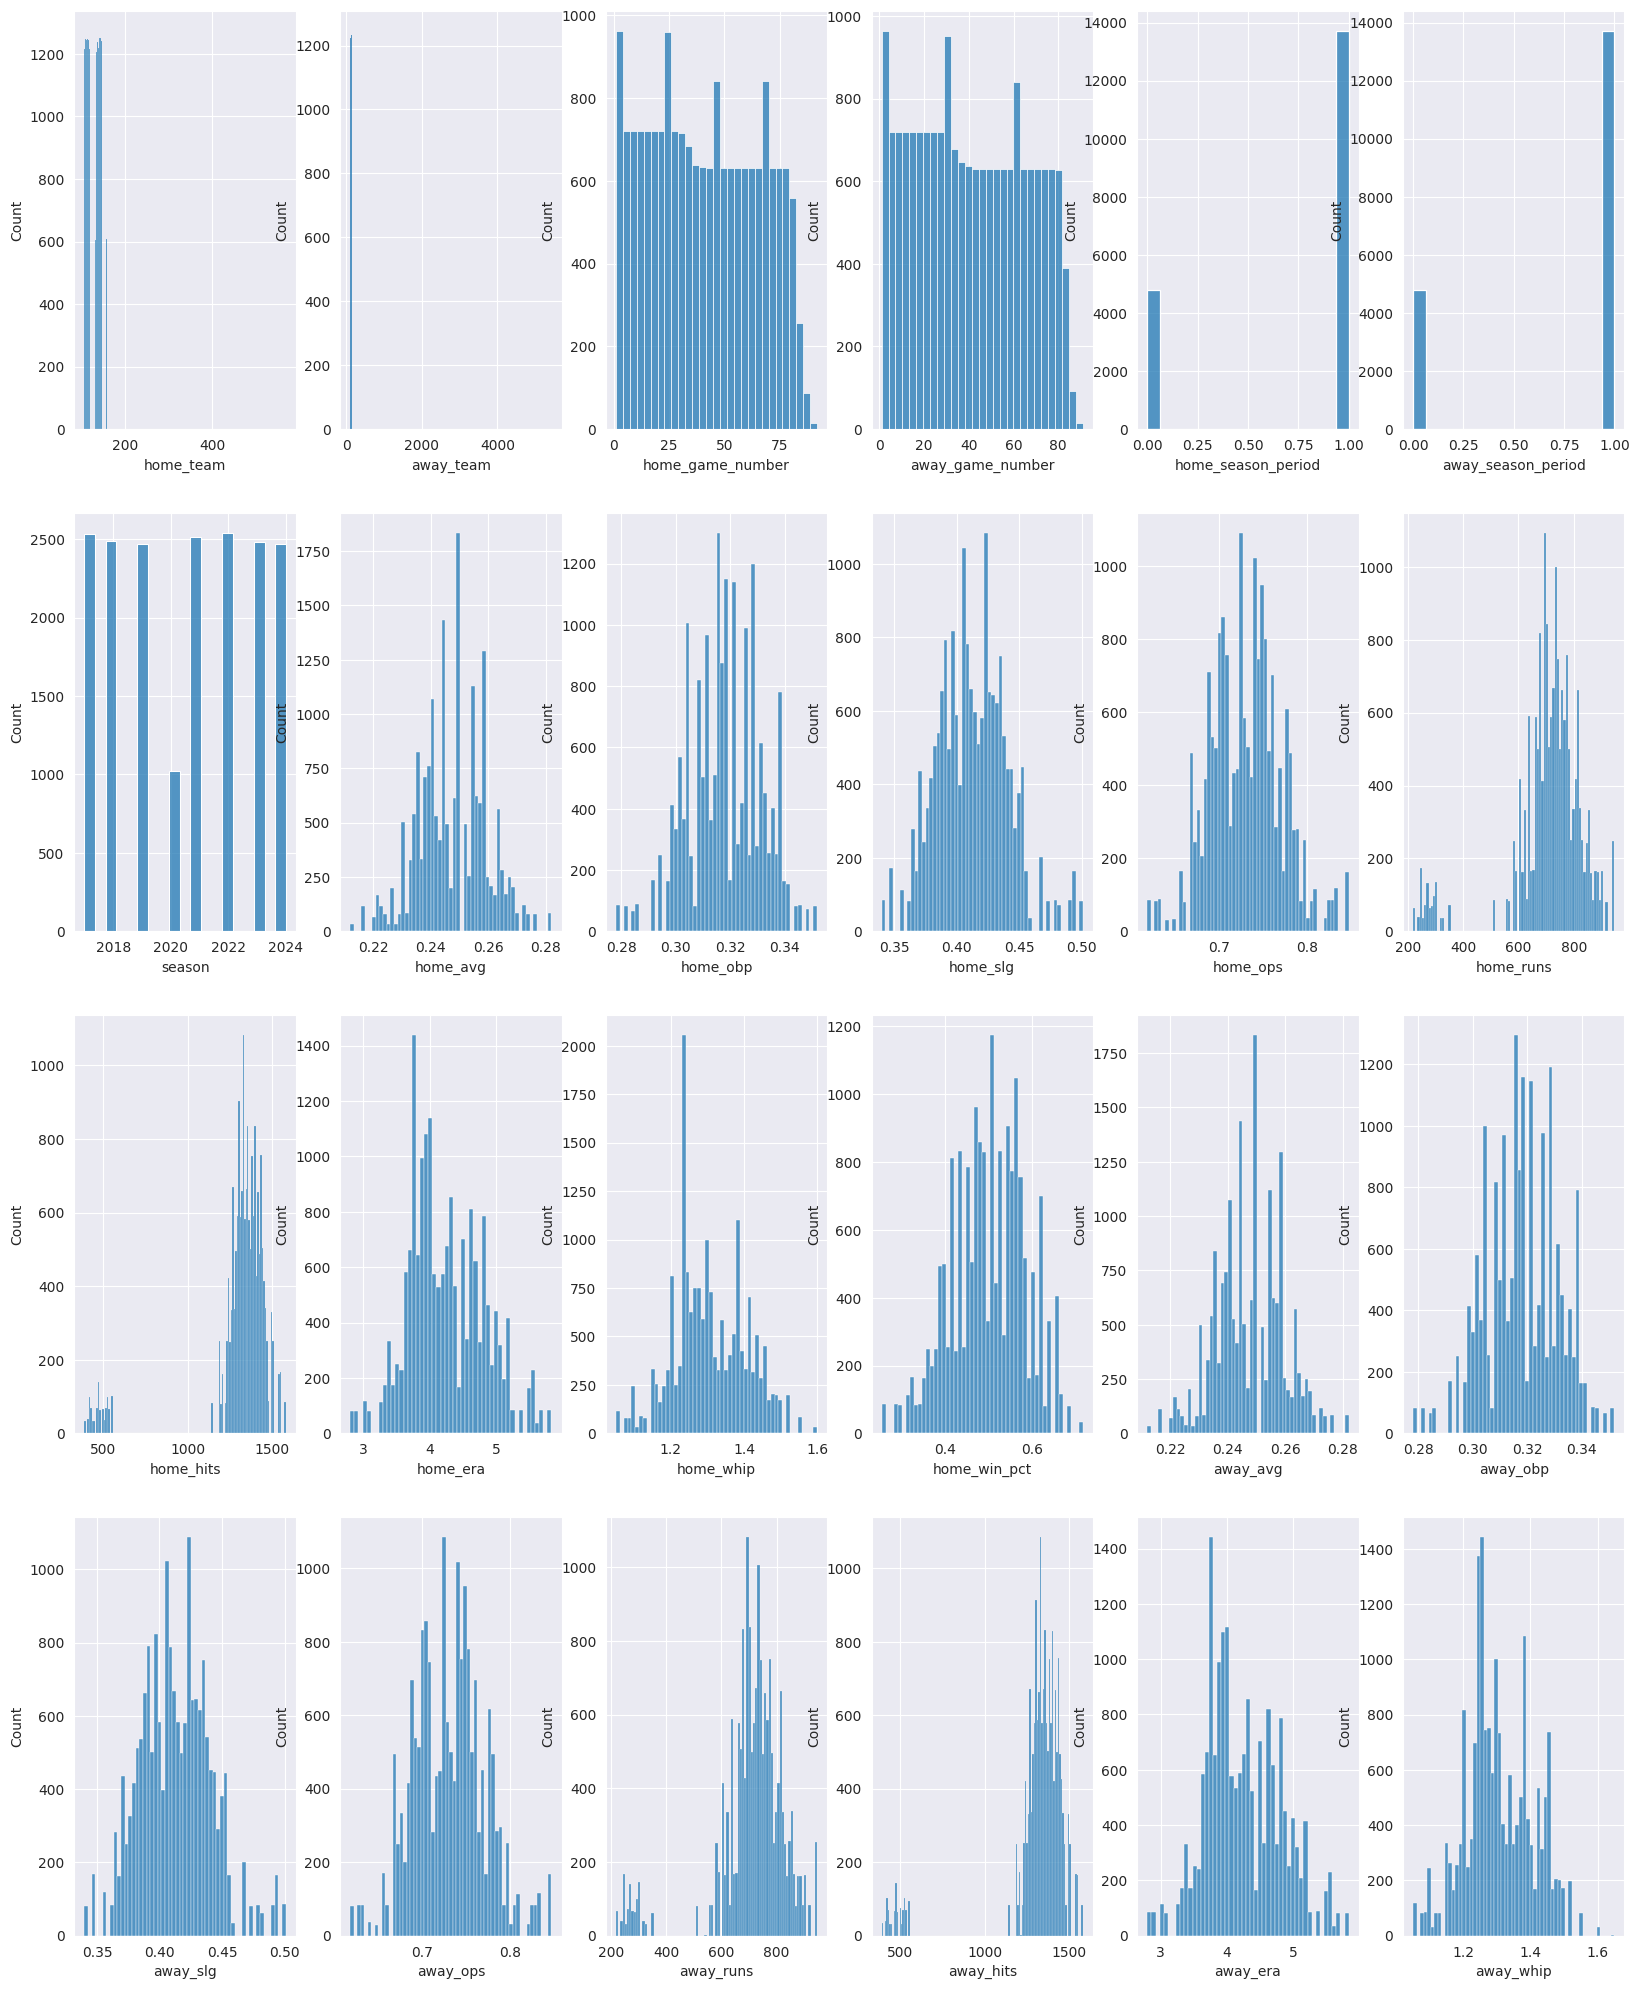

In [10]:

num_cols = X.select_dtypes(exclude='datetime64[ns]').columns

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 25))

for col, ax in zip(num_cols, axes.ravel()):
    sns.histplot(X[col], ax=ax)

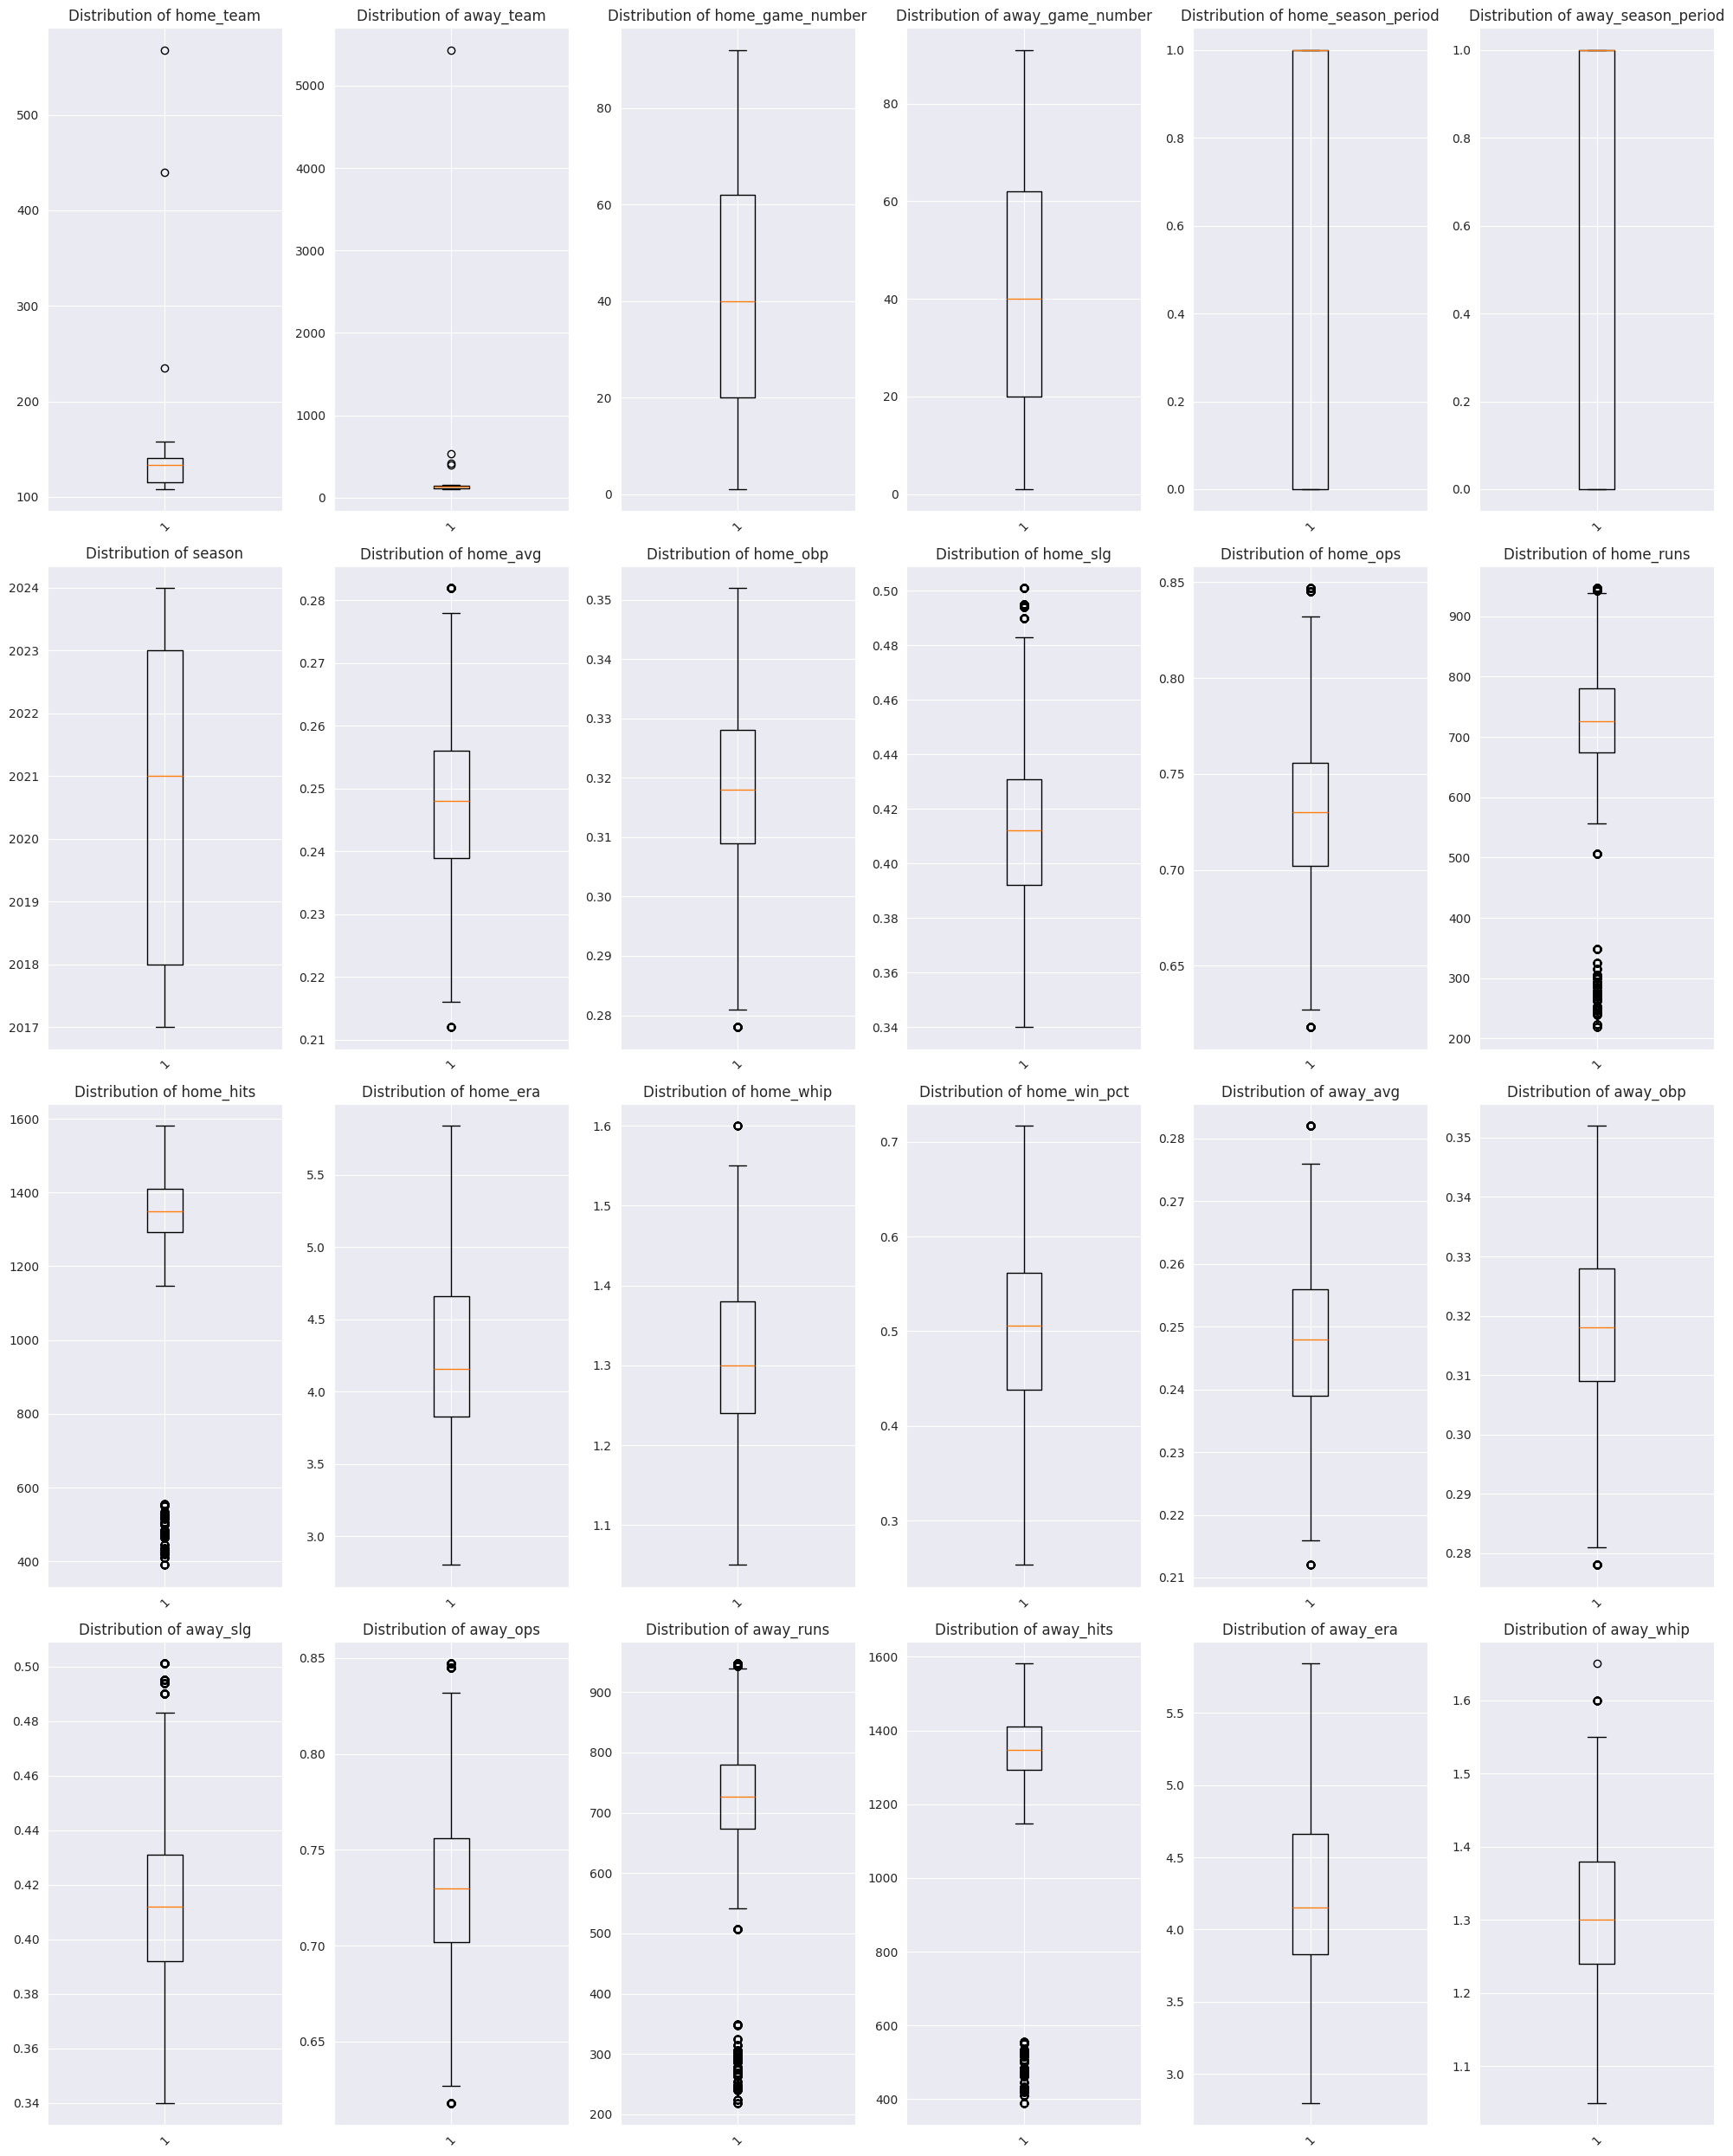

In [11]:
num_cols = X.select_dtypes(exclude='datetime64[ns]').columns

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 25))

for col, ax in zip(num_cols, axes.ravel()):
    ax.boxplot(X[col])
    ax.set_title(f'Distribution of {col}')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
cols_not_to_scale = ['home_team', 'away_team', 'home_game_number', 'away_game_number', 'season', 'home_season_period', 'away_season_period', 'day_of_week', 'month']
robust_feat =['home_avg', 'home_obp', 'home_slg','home_ops', 'home_runs', 'home_hits', 'home_whip', 'away_avg', 'away_obp', 'away_slg', 'away_ops', 'away_runs', 'away_hits', 'away_whip']
standard_feat =['home_era', 'home_win_pct', 'away_era', 'away_win_pct']

len(cols_not_to_scale)+len(robust_feat)+len(standard_feat) == len(X.columns)

True

## Pipeline scaling

In [13]:
standard_transformer = make_pipeline(
                StandardScaler()
                    )

robust_transformer = make_pipeline(
                RobustScaler()
                    )

preproc = make_column_transformer(
                (standard_transformer, standard_feat),
                (robust_transformer, robust_feat),
                ('passthrough', cols_not_to_scale)
                )
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['home_era', 'home_win_pct', 'away_era',
                                  'away_win_pct']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['home_avg', 'home_obp', 'home_slg',
                                  'home_ops', 'home_runs', 'home_hits',
                                  'home_whip', 'away_avg', 'away_obp',
                                  'away_slg', 'away_ops', 'away_runs',
                                  'away_hits', 'away_whip']),
                                ('passthrough', 'passthrough',
                                 ['home_team', 'away_team', 'home_game_number',
                                  'away_game_number', 'season',
                                  'home_season_period', 'away_season_period',
                                  'day_of_week', 'month'])])

In [14]:
preproc.fit_transform(X).shape, preproc.fit_transform(X)

((18530, 27),
 array([[ 0.61119563,  0.29833639, -0.48429289, ...,  0.        ,
          1.        ,  3.        ],
        [ 0.84177318, -0.6590131 ,  1.28759665, ...,  0.        ,
          1.        ,  3.        ],
        [ 1.01914052, -0.29262009, -0.21850946, ...,  0.        ,
          1.        ,  3.        ],
        ...,
        [-0.54169213,  0.73564418, -0.85638969, ...,  1.        ,
          1.        , 10.        ],
        [-1.05605744,  0.87747373, -0.50201178, ...,  1.        ,
          1.        , 10.        ],
        [-0.68358601,  0.87747373, -1.33479987, ...,  1.        ,
          1.        , 10.        ]]))

## Baseline

In [15]:
pipe_baseline = make_pipeline(preproc,
                             LogisticRegression())
pipe_baseline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['home_era', 'home_win_pct',
                                                   'away_era',
                                                   'away_win_pct']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['home_avg', 'home_obp',
                                                   'home_slg', 'home_ops',
                                                   'home_runs', 'home_hits',
                                                   'home_whip', 'away_avg',
                                                   'away_obp', 'away_slg',
                                                   'away_ops', 'away_runs',
                                                   'away_hits', 'away_whip']),
                                                 ('passthrough', 'passthrough',
                                                  ['home_team', 'away_team',
                                                   'home_game_number',
                                                   'away_game_number', 'season',
                                                   'home_season_period',
                                                   'away_season_period',
                                                   'day_of_week', 'month'])])),
                ('logisticregression', LogisticRegression())])

In [16]:
cv_baseline = cross_validate(pipe_baseline, X, y, scoring='accuracy', cv=5)
cv_baseline

/home/lucas/.pyenv/versions/3.10.6/envs/baseball_ai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/lucas/.pyenv/versions/3.10.6/envs/baseball_ai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

{'fit_time': array([5.5120194 , 4.76668859, 5.34272885, 5.14990616, 5.06621385]),
 'score_time': array([0.03854275, 0.04012465, 0.04466462, 0.03222156, 0.05743122]),
 'test_score': array([0.57501349, 0.59282245, 0.5874258 , 0.59282245, 0.58607663])}

## Comparaison plusieurs modèles

In [17]:
X.shape, y.shape

((18530, 27), (18530,))

In [18]:
final_scores = {
    'model_name': ['baseline'],
    'score': [cv_baseline['test_score'].mean()],
    'log': [False]
}

models = [DecisionTreeClassifier(),
          AdaBoostClassifier(),
          GradientBoostingClassifier(),
          KNeighborsClassifier(),
          XGBClassifier(),
          CatBoostClassifier()
         ]

for model in models:
    model_name = str(model)[:-2]
    print(f'Starting cv of model {model_name}')

    pipe = make_pipeline(preproc, model)
    cv_res = cross_validate(pipe, X, y, scoring='accuracy', cv=5)

    final_scores['model_name'].append(model_name)
    final_scores['score'].append(cv_res['test_score'].mean())
    final_scores['log'].append(False)

results_df = pd.DataFrame(final_scores, columns=['model_name', 'score', 'log']).sort_values(by='score', ascending=False)
print(results_df)

Starting cv of model DecisionTreeClassifier
Starting cv of model AdaBoostClassifier


/home/lucas/.pyenv/versions/3.10.6/envs/baseball_ai/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lucas/.pyenv/versions/3.10.6/envs/baseball_ai/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lucas/.pyenv/versions/3.10.6/envs/baseball_ai/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/lucas/.pyenv/versions/3.10.6/envs/baseball_ai/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAM

Starting cv of model GradientBoostingClassifier
Starting cv of model KNeighborsClassifier
Starting cv of model XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ..
Starting cv of model <catboost.core.CatBoostClassifier object at 0x7f214ab6bbb
Learning rate set to 0.032579
0:	learn: 0.6915341	tota

In [19]:
results_df

,model_name,score,log
0,baseline,0.586832,False
2,AdaBoostClassifier,0.580356,False
3,GradientBoostingClassifier,0.578899,False
6,<catboost.core.CatBoostClassifier object at 0x...,0.565461,False
5,"XGBClassifier(base_score=None, booster=None, c...",0.544037,False
4,KNeighborsClassifier,0.518618,False
1,DecisionTreeClassifier,0.512574,False
